<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#02:-xarray,-netcdf-and-zarr" data-toc-modified-id="02:-xarray,-netcdf-and-zarr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>02: xarray, netcdf and zarr</a></span><ul class="toc-item"><li><span><a href="#The-current-defacto-standard-in-atmos/ocean-science" data-toc-modified-id="The-current-defacto-standard-in-atmos/ocean-science-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>The current defacto standard in atmos/ocean science</a></span></li><li><span><a href="#Some-challenges-with-netcdf" data-toc-modified-id="Some-challenges-with-netcdf-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Some challenges with netcdf</a></span></li><li><span><a href="#create-an-xarray" data-toc-modified-id="create-an-xarray-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>create an xarray</a></span></li><li><span><a href="#Download-toy-model-data" data-toc-modified-id="Download-toy-model-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Download toy model data</a></span></li><li><span><a href="#Sort-in-numeric-order" data-toc-modified-id="Sort-in-numeric-order-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Sort in numeric order</a></span></li><li><span><a href="#Make-an-xarray" data-toc-modified-id="Make-an-xarray-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Make an xarray</a></span></li><li><span><a href="#Dump-to-a-zarr-file" data-toc-modified-id="Dump-to-a-zarr-file-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Dump to a zarr file</a></span></li></ul></li></ul></div>

# 02: xarray, netcdf and zarr

Motivation:  how you store your data can an enormous effect on performance.

Four issues:

1) Compression vs. cpu time to uncompress/compress

2) Multithreaded read/writes

3) Performance for cloud storage (Amazon, Google Compute, Azure)

4) Throttling data reads to fit in available memory and avoid swapping ("chunking")

## The current defacto standard in atmos/ocean science


* [netcdf/hdf5](ttps://www.unidata.ucar.edu/software/netcdf/docs/index.html)


## Some challenges with netcdf

* [The Pangeo project](http://pangeo-data.org/)

* [Cloud challenges](https://medium.com/pangeo)

## create an xarray

In [1]:
import glob
import numpy as np
import pdb

In [2]:
#!conda install -y xarray

In [3]:
import context
from westgrid.data_read import download

******************************
context imported. Front of path:
/Users/phil/repos/parallel_python_course/notebooks

******************************



## Download toy model data

In [4]:
#get 10 files, each is the same timestep for a member of a
#10 member ensemble

import numpy as np
root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/small_les'
for i in range(10):
    the_name=f'mar12014_{(i+1):d}_15600.nc'
    print(the_name)
    url='{}/{}'.format(root,the_name)
    download(the_name,root=root)

mar12014_1_15600.nc
trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/small_les/mar12014_1_15600.nc
writing to: mar12014_1_15600.nc

mar12014_1_15600.nc already exists
and is 1455454 bytes
will not overwrite

mar12014_2_15600.nc
trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/small_les/mar12014_2_15600.nc
writing to: mar12014_2_15600.nc

mar12014_2_15600.nc already exists
and is 1455454 bytes
will not overwrite

mar12014_3_15600.nc
trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/small_les/mar12014_3_15600.nc
writing to: mar12014_3_15600.nc

mar12014_3_15600.nc already exists
and is 1455454 bytes
will not overwrite

mar12014_4_15600.nc
trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/small_les/mar12014_4_15600.nc
writing to: mar12014_4_15600.nc

mar12014_4_15600.nc already exists
and is 1455454 bytes
will not overwrite

mar12014_5_15600.nc
trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/small_les/mar12014_5_15600.nc
writing to: mar12014_5_15600.nc

mar12014_5_15600.nc alread

In [5]:
#get 10 files, each is the same timestep for a member of a
#10 member ensemble
import numpy as np
root=Path().resolve()
the_files=root.glob('mar12*nc')
the_files=list(the_files)
the_files

[PosixPath('/Users/phil/repos/parallel_python_course/notebooks/mar12014_2_15600.nc'),
 PosixPath('/Users/phil/repos/parallel_python_course/notebooks/mar12014_3_15600.nc'),
 PosixPath('/Users/phil/repos/parallel_python_course/notebooks/mar12014_10_15600.nc'),
 PosixPath('/Users/phil/repos/parallel_python_course/notebooks/mar12014_8_15600.nc'),
 PosixPath('/Users/phil/repos/parallel_python_course/notebooks/mar12014_9_15600.nc'),
 PosixPath('/Users/phil/repos/parallel_python_course/notebooks/mar12014_5_15600.nc'),
 PosixPath('/Users/phil/repos/parallel_python_course/notebooks/mar12014_4_15600.nc'),
 PosixPath('/Users/phil/repos/parallel_python_course/notebooks/mar12014_1_15600.nc'),
 PosixPath('/Users/phil/repos/parallel_python_course/notebooks/mar12014_6_15600.nc'),
 PosixPath('/Users/phil/repos/parallel_python_course/notebooks/mar12014_7_15600.nc')]

## Sort in numeric order

In [6]:
import glob
import xarray
from matplotlib import pyplot as plt
import numpy as np

def sort_name(pathname):
    """
      sort the filenames so '10' sorts
      last by converting to integers
    """
    str_name=str(pathname.name)
    front, number, back = str_name.split('_')
    return int(number)


## Make an xarray

Now use xarray to stitch together the 10 ensemble members along a new "virtual dimenstion".
The variable "ds"  is an xray dataset, which controls the reads/writes from the
10 netcdf files


In [7]:
the_files.sort(key=sort_name)

#
#  put the 10 ensembles together along a new "ens" dimension
#  using an xray multi-file dataset
#
ds = xarray.open_mfdataset(the_files, engine='netcdf4', concat_dim='ens')
# dump the structure
print(ds)
#
#  3-d ensemble average for temp
#
x = ds['x']
y = ds['y']
z = ds['z']
temp = ds['TABS']
mean_temp = temp[:,  :, :, :].mean(dim='ens')
#
# same for velocity
#
wvel = ds['W']
mean_w = wvel[:,  :, :, :].mean(dim='ens')
#
# now look at the perturbation fields for one ensemble member
#
wvelprime = wvel[0,  :, :, :] - mean_w
Tprime = temp[0,  :, :, :] - mean_temp
flux_prime = wvelprime * Tprime
flux_profile = flux_prime.mean(dim='x').mean(dim='y')
keep_dict = dict(flux_prof=flux_profile, flux_prime=flux_prime.values,
                 wvelprime=wvelprime.values, Tprime=Tprime.values, x=x, y=y, z=z)

<xarray.Dataset>
Dimensions:  (ens: 10, time: 1, x: 50, y: 40, z: 30)
Coordinates:
  * x        (x) float32 0.0 25.0 50.0 75.0 100.0 125.0 150.0 175.0 200.0 ...
  * y        (y) float32 0.0 25.0 50.0 75.0 100.0 125.0 150.0 175.0 200.0 ...
  * z        (z) float32 25.0 50.0 75.0 100.0 125.0 150.0 175.0 200.0 205.0 ...
  * time     (time) float32 169.18056
Dimensions without coordinates: ens
Data variables:
    p        (ens, z) float32 dask.array<shape=(10, 30), chunksize=(1, 30)>
    U        (ens, z, y, x) float32 dask.array<shape=(10, 30, 40, 50), chunksize=(1, 30, 40, 50)>
    V        (ens, z, y, x) float32 dask.array<shape=(10, 30, 40, 50), chunksize=(1, 30, 40, 50)>
    W        (ens, z, y, x) float32 dask.array<shape=(10, 30, 40, 50), chunksize=(1, 30, 40, 50)>
    PP       (ens, z, y, x) float32 dask.array<shape=(10, 30, 40, 50), chunksize=(1, 30, 40, 50)>
    TABS     (ens, z, y, x) float32 dask.array<shape=(10, 30, 40, 50), chunksize=(1, 30, 40, 50)>
    QV       (ens, z, y, 

## Dump to a zarr file

In [8]:
ds.to_zarr('zarr_dir','w')

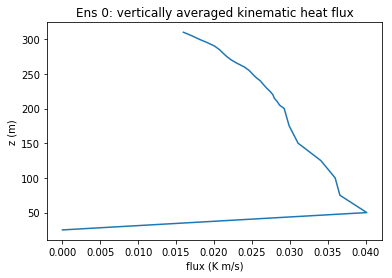

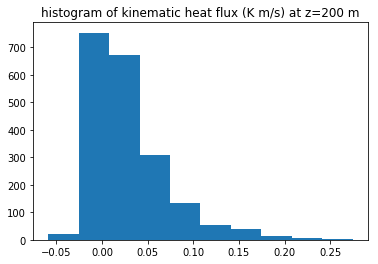

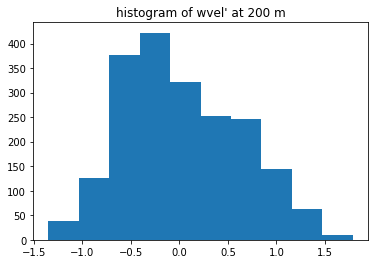

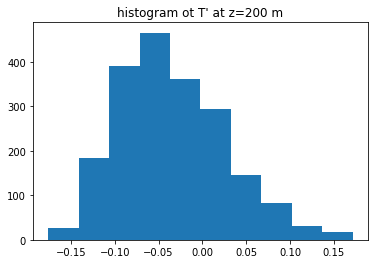

In [9]:
fig1, ax1 = plt.subplots(1, 1)
ax1.plot('flux_prof', 'z', data = keep_dict)
ax1.set(title='Ens 0: vertically averaged kinematic heat flux',
        ylabel='z (m)', xlabel='flux (K m/s)')

fig2, ax2 = plt.subplots(1, 1)
z200 = np.searchsorted(keep_dict['z'], 200)
flux_200 = keep_dict['flux_prime'][z200,:,:].flat
ax2.hist(flux_200)
ax2.set(title='histogram of kinematic heat flux (K m/s) at z=200 m')

fig3, ax3 = plt.subplots(1, 1)
wvel200=keep_dict['wvelprime'][z200,:,:].flat
ax3.hist(wvel200)
ax3.set(title="histogram of wvel' at 200 m")

fig4, ax4 = plt.subplots(1, 1)
Tprime200=keep_dict['Tprime'][z200, :, :].flat
ax4.hist(Tprime200)
ax4.set(title="histogram ot T' at z=200 m");

